In [75]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display, Markdown
from scipy.signal import hilbert
import librosa.display
import librosa.feature
import IPython.display as ipd
from scipy.signal import butter, filtfilt
from ipywidgets import interact, Label
import os

# We make sure we are in the right directory
if not os.path.isdir("assets"):
    %cd heart-sound-notebook

# Basic audio features

- Code inspired from: https://github.com/musikalkemist/AudioSignalProcessingForML
- Accompanying videos: https://www.youtube.com/watch?v=iCwMQJnKk2c&list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0&ab_channel=ValerioVelardo-TheSoundofAI
- The audio files are high-quality textbook examples heart sounds from [Michigan University](https://deepblue.lib.umich.edu/handle/2027.42/120554) (fortunately rescued by deepblue!).

## Loading audio files

We start by loading some heart sounds:

In [76]:
# load audio files with librosa

DURATION = 2.0 # seconds

def load_audio(filename, offset=0, duration=DURATION, normalize=True):
    y, sampling_rate = librosa.load(filename, offset=offset, duration=duration)
    if normalize:
        y = librosa.util.normalize(y)
    return y, sampling_rate

# Audio file name, offset, label, schematic name
# The offset is chosen so that the first sound is a S1 (or S4).
input_matrix = [["assets/heart_sounds/01_apex_normal_s1_s2_supine_bell.mp3", 1.0, "Normal S1 S2", "assets/figures/aortic-normal_s1_s2.png"],
          ["assets/heart_sounds/19_pulm_spilt_s2_persistent_supine_diaph.mp3", 1.5, "Split S2", "assets/figures/pulmonic-ejection_systolic_murmur_with_transient_splitting_s2.png"],
          ["assets/heart_sounds/05_apex_s3_lld_bell.mp3", 1.1, "S3", "assets/figures/s3_gallop.png"],
          ["assets/heart_sounds/03_apex_s4_lld_bell.mp3", 1.0, "S4", "assets/figures/s4_gallop.png"],
          ["assets/heart_sounds/04_apex_mid_sys_click_supine_bell.mp3", 1.2, "Mid systolic click", "assets/figures/mid-systolic-click_mitral_valve_prolapse.png"],
          ["assets/heart_sounds/07_apex_mid_sys_mur_supine_bell.mp3", 1.2, "Mid systolic murmur", "assets/figures/mid-systolic-murmur.png"],
          ["assets/heart_sounds/10_apex_sys_click__late_sys_mur_lld_bell.mp3", 1.1, "Systolic click with late systolic murmur", "assets/figures/systolic_click_with_late_systolic_murmur.png"],
          ]

# Convenience method for getting the label given a sample number
def label(sample):
    return input_matrix[sample][2]

# Convenience object containing the list of (label, sample index)
enum_list = [(row[2], idx) for (idx, row) in enumerate(input_matrix)]
    
# Audio data, sampling rate
orig_data = [load_audio(file, offset) for (file, offset, _, _) in input_matrix]

In [77]:
# Duration of the first audio file

audio_0 = orig_data[0]
sr = audio_0[1]
print(f"Original sampling rate: {sr} Hz")
tot_samples = len(audio_0[0])
duration = 1 / sr * tot_samples
print(f"The audio lasts for {duration} seconds")

Original sampling rate: 22050 Hz
The audio lasts for 2.0 seconds


Each heart sound has specific features characteristic of a condition (or lack of):

In [78]:
def display_schematic_and_audio(sample):
    display(Image(input_matrix[sample][3]))
    display(ipd.Audio(data=orig_data[sample][0], rate=orig_data[sample][1]))

interact(display_schematic_and_audio, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

## Resampling

Heart sounds have frequencies covering 15-1kHz range.
Resampling will lower the dimension of the data and facilitate the training of the model.

Choosing a Nyquist frequency of 1024 Hz, we resample with twice this frequency. Note that an antialiasing filter is automatically applied.

In [79]:
SR = 2048

def resample_all(orig_data_with_sr, target_sr=SR):
    return [librosa.resample(data, orig_sr=orig_sr, target_sr=target_sr, res_type="soxr_vhq")  for (data, orig_sr) in orig_data_with_sr]

data = resample_all(orig_data)

We listen to the resampled audio files just to make sure that we did not introduce any aliasing:

In [80]:
# Web browsers won't play audio with a rate under 3kHz.
# Just for the sake of playing the downsampled files, we upsample to the minimum allowed sr.

DUMMY_SR = 3000

dummy_data = resample_all(orig_data, DUMMY_SR)

def display_schematic_and_audio(sample):
    orig_sr = orig_data[sample][1]
    display(Label(f"Original sampling rate ({orig_sr} Hz):"))
    display(ipd.Audio(data=orig_data[sample][0], rate=orig_sr))
    display(Label("Down-sampled:"))
    display(ipd.Audio(data=dummy_data[sample], rate=DUMMY_SR))
    
interact(display_schematic_and_audio, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

We can also look at the waveform to check that we are not loosing any important details:

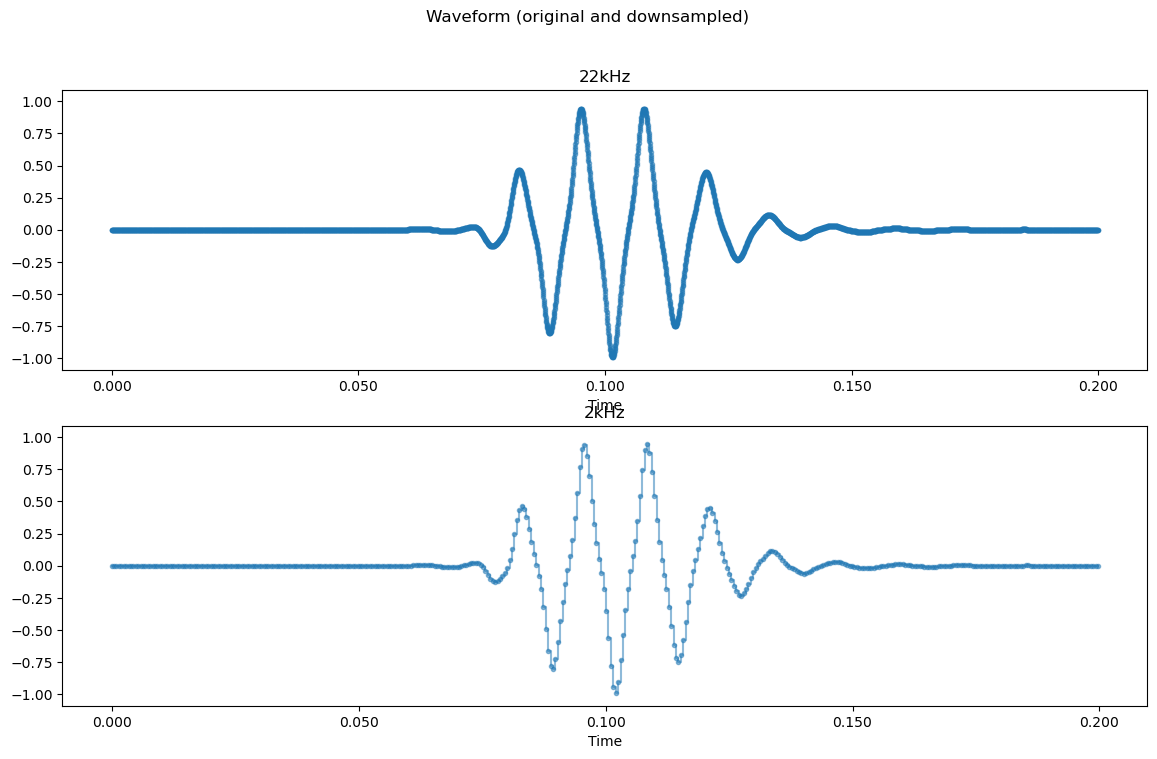

In [81]:
def plot_original_and_downsampled(signal, signal_resampled, start_ratio=0, end_ratio=1):
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(signal[int(len(signal)*start_ratio):int(len(signal)*end_ratio)], sr=sr, alpha=0.5, marker=".")
    plt.title("22kHz")

    plt.subplot(2, 1, 2)
    librosa.display.waveshow(signal_resampled[int(len(signal_resampled)*start_ratio):int(len(signal_resampled)*end_ratio)], sr=SR, alpha=0.5, marker=".")
    plt.title("2kHz")

    plt.suptitle("Waveform (original and downsampled)")
    plt.show()

plot_original_and_downsampled(orig_data[0][0], data[0], 0.02, 0.12)

## Waveform

Let us look at the waveform of some common heart sounds:

In [82]:
def plot_waveform(signal, title, start_ratio=0, end_ratio=1):
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(signal[int(len(signal)*start_ratio):int(len(signal)*end_ratio)], sr=SR, alpha=0.5, marker=".")
    plt.title(title)
    plt.show()

def display_schematic_and_audio(sample):
    plot_waveform(data[sample], f"Waveform ({label(sample)})", 0, 0.4)
    
interact(display_schematic_and_audio, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

### Observations

- Durations:
  - S1 and S2: ~80ms
  - S3 and S4: ~150ms
  - Clicks: ~50ms
  - P2-A2 (first and second sounds of split S2): ~60ms
- Pitch:
  - S1 and S2: about 60 Hz
  - S2 and S3: lower than S1 and S2
  - Clicks: higher than S1 and S2. Messy.
- Amplitude:
  - S1 and S2: large. S1 > S2 in some cases.
  - S2 and S3: medium
  - Clicks: low

Based on these observations, we should aim to have a temporal resolution < 25ms (half of the smallest feature duration).

## Time domain

We start by defining the properties of the sliding window:

In [83]:
# Attention: when used as n_fft in stft, FRAME_SIZE must be a power of 2
FRAME_SIZE = 2**6  # 64 samples. Corresponds to ~32ms at 2kHz
HOP_LENGTH = 2**4  # 16 samples. Corresponds to ~16ms at 2kHz

To get the envelope, we compute the Hilbert transform to get the analytic form. From it we can extract the instantaneous amplitude (envelope). We could also get the instantaneous frequency.
We apply a low-pass filter to smooth the envelope. Subsampling would probably also work fine.

In [84]:
# Compute smoothed envelope

def smooth_envelope(signal, rate):
    signal_analytic = hilbert(signal)
    instantaneous_amplitude = np.abs(signal_analytic)

    # Design a low-pass Butterworth filter
    cutoff = 30  # cutoff frequency in Hz
    order = 2    # filter order
    b, a = butter(order, cutoff, btype='low', fs=rate)  # normalized frequency (Nyquist)

    # zero-phase filtering
    envelope = filtfilt(b, a, instantaneous_amplitude)

    return envelope

# Compute envelopes
env = [smooth_envelope(signal, SR) for signal in data]

# Time vector
t_env = np.linspace(0, DURATION, len(env[0]))

#def ifreq(analytic, rate):
#  instantaneous_phase = np.unwrap(np.angle(analytic))
#  return np.diff(instantaneous_phase) * rate / (2.0*np.pi)

#ifreq_normal = ifreq(normal_analytic, SR)
#ifreq_s2_split = ifreq(s2_split_analytic, SR)
#ifreq_s3 = ifreq(s3_analytic, SR)
#ifreq_mid_syst_murmur = ifreq(mid_syst_murmur_analytic, SR)

# Time axis for freq (one sample shorter)
#t_freq = t_amp[1:]

We also compute the RMS energy:

In [85]:
# Computing RMS energy

rms = [librosa.feature.rms(y=signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0] for signal in data]

# Time vector from frames
frames = range(len(rms[0]))
t_rms = librosa.frames_to_time(frames, sr=SR, hop_length=HOP_LENGTH)

And Zero-crossing rate:

In [86]:
# Computing ZCR

zcr = [librosa.feature.zero_crossing_rate(y=signal, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0] for signal in data]

# Time vector from frames
frames = range(len(rms[0]))
t_zcr = librosa.frames_to_time(frames, sr=SR, hop_length=HOP_LENGTH)

In [87]:
def plot_temporal_features(sample):
    plt.figure(figsize=(14, 6))

    librosa.display.waveshow(data[sample], sr=SR, alpha=0.5)
    plt.plot(t_env, env[sample], color="r")
    plt.plot(t_rms, rms[sample], color="g")
    plt.plot(t_zcr, zcr[sample], color="y")
    plt.ylim((-1, 1))
    plt.title(f"Temporal features ({label(sample)})")
    plt.legend(["", "Waveform", "AE", "RMS energy", "ZCR"])

    plt.show()

interact(plot_temporal_features, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

## Frequency domain

We use FFT to compute the amplitude spectrum.

Note that FFT produces as many frequencies as input points (and that it is wise to use a power of 2).

In [88]:
def amplitude_spectrum(signal):
    fft = np.fft.fft(signal)
    return np.abs(fft)

# Frequency vector
frequencies = librosa.fft_frequencies(sr=SR, n_fft=len(data[0]))

# The amplitude spectrum is symmetrical around the Nyquist frequency.
# We discard the right side by keeping range 0 -> len(frequencies)
fft = [amplitude_spectrum(signal)[:len(frequencies)] for signal in data]

In [90]:
def plot_spectrum(sample):
    plt.figure(figsize=(14, 5))
    plt.plot(frequencies, fft[sample])
    plt.xlabel('Frequency (Hz)')
    plt.title(f"Amplitude spectrum ({label(sample)})")
    plt.show()

interact(plot_spectrum, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

We can also display the log-power spectrum:

In [91]:
def plot_spectrum(sample):
    plt.figure(figsize=(14, 5))
    plt.plot(frequencies[:2048], librosa.power_to_db(fft[sample] **2)[:2048])
    plt.xlabel('Frequency (Hz)')
    plt.xlabel('dB')
    plt.title(f"Log-power spectrum ({label(sample)})")
    plt.show()

interact(plot_spectrum, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

## Time-frequency domain

### Spectral centroid and bandwidth

- Spectral centroid: centre of gravity of mass of the spectrum (mean frequency).
- Spectral bandwidth: spread of a signal’s frequency content around its spectral centroid (equivalent of a standard deviation).

In [92]:
FRAME_SIZE = 2**6
HOP_LENGTH = 2**3

In [93]:
# Spectral centroid
sc = [librosa.feature.spectral_centroid(y=signal, sr=SR, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0] for signal in data]

# Spectral bandwidth
sb = [librosa.feature.spectral_bandwidth(y=signal, sr=SR, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0] for signal in data]

# Time vector
frames = range(len(sc[0]))
t = librosa.frames_to_time(frames, sr=SR, hop_length=HOP_LENGTH)

In [94]:
def plot_spectral_features(sample):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(data[sample] * max(sc[sample]) * 2, sr=SR, alpha=0.5)
    plt.plot(t, sc[sample], color="r")
    plt.fill_between(t, sc[sample] - sb[sample], sc[sample] + sb[sample], color="orange", alpha=0.2)
    plt.ylabel("Hz")
    plt.ylim(0, None)
    plt.title(f"Spectral features ({label(sample)})")
    plt.legend(["", "Waveform", "Spectral centroid", "Spectral bandwidth"])
    plt.show()

interact(plot_spectral_features, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

### Spectrograms

We plot varius spectrograms:
- STFT
- Mel spectrogram
- MFCC

Notes about STFT:
- By default, window size == n_fft == FRAME_SIZE
- The default is a centered Hann window (zero padding)
- Because the number of frequency bins is equal to the frame size (+1), there is a **time-frequency localization trade-off**: smaller frame size improves the temporal resolution of the STFT (i.e. the ability to discriminate impulses that are closely spaced in time) at the expense of frequency resolution (i.e. the ability to discriminate pure tones that are closely spaced in frequency).

In [95]:
# Attention: when used as n_fft in stft, FRAME_SIZE must be a power of 2
#FRAME_SIZE = 2**6 # 64 samples. Corresponds to ~32ms at 2kHz
FRAME_SIZE = 2**5 # 32 samples. Corresponds to ~16ms at 2kHz
#HOP_LENGTH = 2**3 # 8 samples. Corresponds to ~4ms at 2kHz
#HOP_LENGTH = 2**2 # 4 samples. Corresponds to ~2ms at 2kHz
HOP_LENGTH = 2**1 # 2 samples. Corresponds to ~1ms at 2kHz
N_MFCC = 13

In [96]:
def plot_spectrograms(sample):
    # Compute STFT
    stft = librosa.stft(data[sample], n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    stft_power = np.abs(stft) ** 2
    stft_logpower = librosa.power_to_db(stft_power)

    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=data[sample], sr=SR, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH, n_mels=N_MFCC)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Compute MFCC
    # Given we use the Mel spectrogram as inputs, it makes sense to use the same number of output bins in both functions.
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=N_MFCC, sr=SR)


    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(17, 10), gridspec_kw={'height_ratios': [1, 5, 5, 5]})
    librosa.display.waveshow(data[sample], sr=SR, ax=ax1)
    ax1.set_title("Waveform", rotation=270, x=1.05, y=0.1)
    img = librosa.display.specshow(stft_logpower,
                             sr=SR,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="log",
                             cmap='inferno',
                             ax=ax2)
    #fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    ax2.set_title("Log-power spectrogram", rotation=270, x=1.05, y=0)

    librosa.display.specshow(log_mel_spectrogram,
                             sr=SR,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="mel",
                             cmap='inferno',
                             ax=ax3)
    ax3.set_title("Mel spectrogram", rotation=270, x=1.05, y=0.1)

    librosa.display.specshow(mfccs,
                             sr=SR,
                             hop_length=HOP_LENGTH,
                             x_axis="time",
                             y_axis="mel",
                             cmap='inferno',
                             ax=ax4)
    ax4.set_title("MFCC", rotation=270, x=1.05, y=0.4)
    plt.suptitle(f"Spectrograms ({label(sample)})")
    plt.show()

interact(plot_spectrograms, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

Observations:
- The temporal resolution (frame size) was sufficient for making the S2 split clearly visible.
- The systolic murmur is easily identifiable despite a much larger steady noise level than in other recordings.

### Reassigned spectrogram

In a reassigned spectrogram, the time and frequency bins are changing to adapt to sudden changes in the signal.
This prevents an event to be smeared over several bins boundaries.

Here is an example using synthetic clicks and a chirp:

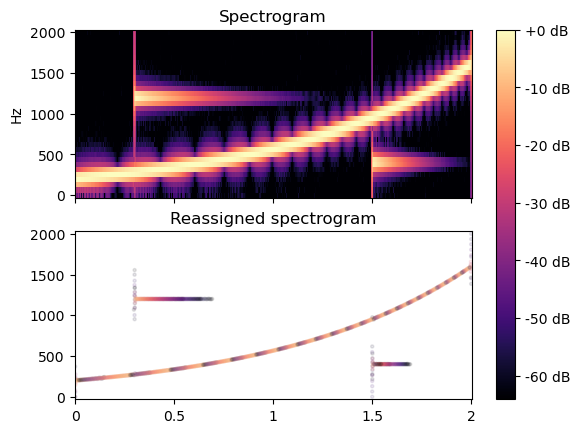

In [97]:
n_fft = 64
sr = 4000
y = 1e-3 * librosa.clicks(times=[0.3], sr=sr, click_duration=1.0,
                          click_freq=1200.0, length=8000) +\
    1e-3 * librosa.clicks(times=[1.5], sr=sr, click_duration=0.5,
                          click_freq=400.0, length=8000) +\
    1e-3 * librosa.chirp(fmin=200, fmax=1600, sr=sr, duration=2.0) +\
    1e-6 * np.random.randn(2*sr)

display(ipd.Audio(data=y, rate=sr))

freqs, times, mags = librosa.reassigned_spectrogram(y=y, sr=sr,
                                                    n_fft=n_fft)
mags_db = librosa.amplitude_to_db(mags, ref=np.max)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
img = librosa.display.specshow(mags_db, x_axis="s", y_axis="linear", sr=sr,
                         hop_length=n_fft//4, ax=ax[0])
ax[0].set(title="Spectrogram", xlabel=None)
ax[0].label_outer()
ax[1].scatter(times, freqs, c=mags_db, cmap="magma", alpha=0.1, s=5)
ax[1].set_title("Reassigned spectrogram")
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.show()

Both the traditional spectrogram and reassigned spectrogram contain the same number of 'data points', but while they are homogenously mapping the frequency space in the former case, they are localized to 'interesting signals' in the latter case.

Let us see how the spectrograms look like for the heart sounds:

In [98]:
# Compute the reassigned spectrogram

def spectogram_reassigned_spectogram(sample):
    freqs, times, mags = librosa.reassigned_spectrogram(y=data[sample], sr=SR, hop_length=HOP_LENGTH, n_fft=FRAME_SIZE, center=False)
    mags_db = librosa.amplitude_to_db(mags, ref=np.max)
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(17, 8))
    img = librosa.display.specshow(mags_db, x_axis="s", y_axis="linear", sr=SR,
                             hop_length=HOP_LENGTH, ax=ax[0])
    ax[0].set(title="Spectrogram", xlabel=None)
    ax[0].label_outer()
    ax[1].scatter(times, freqs, c=mags_db, cmap="magma", alpha=0.5, s=5)
    ax[1].set_title("Reassigned spectrogram")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Instantaneous frequency (Hz)")
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    plt.suptitle(f"{label(sample)}")
    plt.show()

interact(spectogram_reassigned_spectogram, sample=enum_list);

interactive(children=(Dropdown(description='sample', options=(('Normal S1 S2', 0), ('Split S2', 1), ('S3', 2),…

#### Observations

- Normal: We can clearly see that the reassigned spectrogram contains much finer details (frequency axis). The horizontal lines are the heart sounds with their harmonics.
- S2 split: it is much more difficult to recognize an S2 split in the reassigned spectrogram.
- S3: S3 sounds are visible with their lower pitch than S1 and S2.
- S4: S4 is visible as a low pitch sound preceding S1, but the reassigned spectrogram becomes difficult to read.
- Mid systolic click: The click is easily identifiable due to the lack of horizontal 60 Hz fundamental frequency.
- Mid systolic murmur: The murmur is also clearly visible despite the constant background noise.
- Mid systolic click with murmur: Can be distinguished from the systolic murmur alone by the presence of a high energetic front initiating the murmur.